In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import pickle

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.api import VAR

In [2]:
with open('../preprocess_data/pickle_preprocess.pkl', 'rb') as file:
    df = pickle.load(file)

with open('../preprocess_data/pickle_final.pkl', 'rb') as file:
    df2 = pickle.load(file)

In [3]:
df.tail()

,조이혼율,GNI 증감률,총지수_증감률,조혼인율,여성초혼 연령,여성경제 활동참가율,알코올 질환 인구 10만 명당 여성 사망률,주택가격지수_전국,GDP디플레이터_증감률
2018-01-01,2.1,1.1,1.5,5.0,30.40,52.9,2.6,90.6,0.5
2019-01-01,2.2,0.0,0.4,4.7,30.59,53.5,2.5,90.3,-0.8
2020-01-01,2.1,-0.1,0.5,4.2,30.78,52.8,2.8,95.2,1.6
2021-01-01,2.0,3.7,2.5,3.8,31.08,53.3,NaN,104.6,2.8
2022-01-01,1.8,-0.5,5.1,3.7,31.26,54.6,NaN,99.7,1.3


In [4]:
# selected feature
devorce = df[['조이혼율']]
gni_rate = df[['GNI 증감률']]
cpi_tot = df[['총지수_증감률']]
marriage = df[['조혼인율']]
mar_age = df[['여성초혼 연령']]
female = df[['여성경제 활동참가율']]
alcohol = df[['알코올 질환 인구 10만 명당 여성 사망률']]
house_price_who = df[['주택가격지수_전국']]
gdp_rate = df[['GDP디플레이터_증감률']]

# target
y = df2[['출생아수']]
df['출생아수'] = df2['출생아수']

df2['학령인구'] = df2['초등학교'] + df2['중학교'] + df2['고등학교'] + df2['대학교']
target = df2['학령인구']
df['학령인구'] = df2['학령인구']

data = [devorce, gni_rate, cpi_tot, marriage, mar_age, female, alcohol, house_price_who, gdp_rate, y, target]
name = ['조이혼율','GNI 증감률','총지수_증감률','조혼인율','여성초혼 연령','여성경제 활동참가율','알코올 질환 인구 10만 명당 여성 사망률','주택가격지수_전국','GDP디플레이터_증감률','출생아수','학령인구']
print(len(data), len(name))

11 11


In [5]:
df.tail()

,조이혼율,GNI 증감률,총지수_증감률,조혼인율,여성초혼 연령,여성경제 활동참가율,알코올 질환 인구 10만 명당 여성 사망률,주택가격지수_전국,GDP디플레이터_증감률,출생아수,학령인구
2018-01-01,2.1,1.1,1.5,5.0,30.40,52.9,2.6,90.6,0.5,326800.0,8263000.0
2019-01-01,2.2,0.0,0.4,4.7,30.59,53.5,2.5,90.3,-0.8,302700.0,8075000.0
2020-01-01,2.1,-0.1,0.5,4.2,30.78,52.8,2.8,95.2,1.6,272300.0,7888000.0
2021-01-01,2.0,3.7,2.5,3.8,31.08,53.3,NaN,104.6,2.8,260600.0,7699000.0
2022-01-01,1.8,-0.5,5.1,3.7,31.26,54.6,NaN,99.7,1.3,249100.0,7482000.0


# 정상성 검정

In [6]:
stat_data = []
stat_name = []
# non-stationary
nstat_data = []
nstat_name = []
diff1_data = []
diff1_name = []
diff2_data = []
diff2_name = []

# print(len(data),len(name))

for index,var in enumerate(data):
# ADF 검정 수행
    result = kpss(var.dropna())
    adf_statistic = result[0]
    p_value = result[1]

    # print(f'ADF 통계량: {adf_statistic}')
    # print(f'p-value: {p_value}')

    if p_value <= 0.05:
        print(f'KPSS 검정결과 {name[index]} 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.')

        # log = np.log1p(var)
        # log_first = pd.Series(var).diff().dropna()
        log_first = np.log1p(var.dropna()).diff().dropna()

        result = kpss(log_first)
        adf_statistic = result[0]
        p_value = result[1]

        # print(f'>> ADF 통계량: {adf_statistic}')
        # print(f'>> p-value: {p_value}')

        if p_value <= 0.05:
            print(f'>> KPSS 검정결과 1차분한 {name[index]} 시계열 데이터가 정상성을 가지지 않습니다.')

            log_second = np.log1p(var).diff().diff().dropna()

            result = kpss(log_second)
            adf_statistic = result[0]
            p_value = result[1]

            # print(f'>>>> ADF 통계량: {adf_statistic}')
            # print(f'>>>> p-value: {p_value}')

            if p_value <=0.05:
                print(f'>>>> KPSS 검정결과 2차분한 {name[index]} 시계열 데이터가 정상성을 가지지 않습니다.')
                nstat_data.append(var)
                nstat_name.append(name[index])

            else:
                print(f'>>>> KPSS 검정결과 2차분한 {name[index]} 시계열 데이터가 정상성을 가집니다.')
                diff2_data.append(var)
                diff2_name.append(name[index])

        else:
            print(f'>>>> KPSS 검정결과 1차분한 {name[index]} 시계열 데이터가 정상성을 가집니다.')
            diff1_data.append(var)
            diff1_name.append(name[index])

    else:
        print(f'ADF 검정결과 {name[index]} 시계열 데이터가 정상성을 가집니다.')
        stat_data.append(var)
        stat_name.append(name[index])


    print()

print("정상성 :", stat_name)
print("1차분결과 정상성: ", diff1_name)
print("2차분결과 정상성: ", diff2_name)
print('정상성 안띰 :', nstat_name)

ADF 검정결과 조이혼율 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 GNI 증감률 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 GNI 증감률 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 총지수_증감률 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 총지수_증감률 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 조혼인율 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 조혼인율 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 여성초혼 연령 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 여성초혼 연령 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 여성경제 활동참가율 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 여성경제 활동참가율 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 알코올 질환 인구 10만 명당 여성 사망률 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 알코올 질환 인구 10만 명당 여성 사망률 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 주택가격지수_전국 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 주택가격지수_전국 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 GDP디플레이터_증감률 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>> KPSS 검정결과 1차분한 GDP디플레이터_증감률 시계열 데이터가 정상성을 가지지 않습니다.
>>>> KPSS 검정결과 2차분한 GDP디플레이터_증감률 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 출생아수 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KP

/var/folders/k8/xm42xp_16cs6fgtvp6ymr9l40000gn/T/ipykernel_6649/1128162876.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(var.dropna())
/var/folders/k8/xm42xp_16cs6fgtvp6ymr9l40000gn/T/ipykernel_6649/1128162876.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(var.dropna())
/var/folders/k8/xm42xp_16cs6fgtvp6ymr9l40000gn/T/ipykernel_6649/1128162876.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(var.dropna())
/var/folders/k8/xm42xp_16cs6fgtvp6ymr9l40000gn/T/ipykernel_6649/1128162876.py:29: InterpolationWarning: The test statistic is outside of the range of p-values avai

In [7]:
kpss_result = pd.DataFrame()
kpss_index = df.columns
kpss_result.index = kpss_index
kpss_result['정상성'] = ['O' if i in stat_name else "X" for i in kpss_index]
kpss_result['1차분 정상성'] = ['O' if i in diff1_name else "X" for i in kpss_index]
kpss_result['2차분 정상성'] = ['O' if i in diff2_name else "X" for i in kpss_index]
kpss_result['정상성 안띰'] = ['O' if i in nstat_name else "X" for i in kpss_index]
kpss_result

def replace_after_o(row):
    o_found = False
    for i in range(len(row)):
        if row[i] == 'O':
            o_found = True
        elif o_found and row[i] == 'X':
            row[i] = '-'
    return row

# Apply the function to each row of the dataframe
kpss_result = kpss_result.apply(replace_after_o, axis=1)
kpss_result

,정상성,1차분 정상성,2차분 정상성,정상성 안띰
조이혼율,O,-,-,-
GNI 증감률,X,O,-,-
총지수_증감률,X,O,-,-
조혼인율,X,O,-,-
여성초혼 연령,X,O,-,-
여성경제 활동참가율,X,O,-,-
알코올 질환 인구 10만 명당 여성 사망률,X,O,-,-
주택가격지수_전국,X,O,-,-
GDP디플레이터_증감률,X,X,O,-
출생아수,X,O,-,-


# 상호인과성 검정

In [8]:
stat_name

['조이혼율']

In [9]:
max_lag = 10
alpha = 0.05

stat_data = [df[[stat_name[i]]] for i in range(len(stat_name))]

for i in range(len(stat_data)):
  test_x2y = pd.concat([stat_data[i], np.log1p(y).diff()], axis = 1).dropna()
  test_y2x = pd.concat([np.log1p(y).diff(), stat_data[i]], axis = 1).dropna()
  print(stat_name[i])
  try:
    result_x2y = grangercausalitytests(test_x2y, maxlag = max_lag, verbose = False)
    result_y2x = grangercausalitytests(test_y2x, maxlag = max_lag, verbose = False)
    for j in range(1, max_lag + 1):
      if result_x2y[j][0]['ssr_ftest'][1] < alpha and result_y2x[j][0]['ssr_ftest'][1] < alpha:
        print(f'{j}번째 lag는 "선형적인" 상호인과성이 있다.')
    for k in range(1, max_lag + 1):
      if result_x2y[k][0]['ssr_chi2test'][1] < alpha and result_y2x[k][0]['ssr_chi2test'][1] < alpha:
        print(f'{k}번째 lag는 "비선형적인" 상호인과성이 있다.')
  except:
    pass
  print()

조이혼율
9번째 lag는 "비선형적인" 상호인과성이 있다.
10번째 lag는 "비선형적인" 상호인과성이 있다.



In [10]:
diff1_name

['GNI 증감률',
 '총지수_증감률',
 '조혼인율',
 '여성초혼 연령',
 '여성경제 활동참가율',
 '알코올 질환 인구 10만 명당 여성 사망률',
 '주택가격지수_전국',
 '출생아수']

In [11]:
diff1_data = [df[[diff1_name[i]]] for i in range(len(diff1_name))]

for i in range(len(diff1_data)):
  test_x2y = pd.concat([np.log1p(diff1_data[i]).diff(), np.log1p(y).diff()], axis = 1).dropna()
  test_y2x = pd.concat([np.log1p(y).diff(), np.log1p(diff1_data[i]).diff()], axis = 1).dropna()
  print(diff1_name[i])
  try:
    result_x2y = grangercausalitytests(test_x2y, maxlag = max_lag, verbose = False)
    result_y2x = grangercausalitytests(test_y2x, maxlag = max_lag, verbose = False)
    for j in range(1, max_lag + 1):
      if result_x2y[j][0]['ssr_ftest'][1] < alpha and result_y2x[j][0]['ssr_ftest'][1] < alpha:
        print(f'{j}번째 lag는 "선형적인" 상호인과성이 있다.')
    for k in range(1, max_lag + 1):
      if result_x2y[k][0]['ssr_chi2test'][1] < alpha and result_y2x[k][0]['ssr_chi2test'][1] < alpha:
        print(f'{k}번째 lag는 "비선형적인" 상호인과성이 있다.')
  except:
    print('상호인과성이 없다.')
  print()

GNI 증감률
10번째 lag는 "비선형적인" 상호인과성이 있다.

총지수_증감률
상호인과성이 없다.

조혼인율
6번째 lag는 "비선형적인" 상호인과성이 있다.
7번째 lag는 "비선형적인" 상호인과성이 있다.
8번째 lag는 "비선형적인" 상호인과성이 있다.
9번째 lag는 "비선형적인" 상호인과성이 있다.
10번째 lag는 "비선형적인" 상호인과성이 있다.

여성초혼 연령
8번째 lag는 "비선형적인" 상호인과성이 있다.
9번째 lag는 "비선형적인" 상호인과성이 있다.
10번째 lag는 "비선형적인" 상호인과성이 있다.

여성경제 활동참가율
상호인과성이 없다.

알코올 질환 인구 10만 명당 여성 사망률

주택가격지수_전국
7번째 lag는 "비선형적인" 상호인과성이 있다.
10번째 lag는 "비선형적인" 상호인과성이 있다.

출생아수



In [12]:
diff2_name

['GDP디플레이터_증감률', '학령인구']

In [13]:
diff2_data = [df[[diff2_name[i]]] for i in range(len(diff2_name))]

for i in range(len(diff2_data)):
  test_x2y = pd.concat([np.log1p(diff2_data[i]).diff().diff(), np.log1p(y).diff()], axis = 1).dropna()
  test_y2x = pd.concat([np.log1p(y).diff(), np.log1p(diff2_data[i]).diff().diff()], axis = 1).dropna()
  print(diff2_name[i])
  try:
    result_x2y = grangercausalitytests(test_x2y, maxlag = max_lag, verbose = False)
    result_y2x = grangercausalitytests(test_y2x, maxlag = max_lag, verbose = False)
    for j in range(1, max_lag + 1):
      if result_x2y[j][0]['ssr_ftest'][1] < alpha and result_y2x[j][0]['ssr_ftest'][1] < alpha:
        print(f'{j}번째 lag는 "선형적인" 상호인과성이 있다.')
    for k in range(1, max_lag + 1):
      if result_x2y[k][0]['ssr_chi2test'][1] < alpha and result_y2x[k][0]['ssr_chi2test'][1] < alpha:
        print(f'{k}번째 lag는 "비선형적인" 상호인과성이 있다.')
  except:
    print('상호인과성이 없다.')
  print()

GDP디플레이터_증감률
상호인과성이 없다.

학령인구



In [14]:
features_name = ['조이혼율','GNI 증감률','조혼인율','여성초혼 연령','주택가격지수_전국']
features_names = ['조이혼율_pre','GNI 증감률_pre','조혼인율_pre','여성초혼 연령_pre','주택가격지수_전국_pre']

In [15]:
pre_divorce = df[features_name[0]]
pre_gni_rate = np.log1p(df[features_name[1]]).diff()
pre_marriage = np.log1p(df[features_name[2]]).diff()
pre_mar_age = np.log1p(df[features_name[3]]).diff()
pre_house_price_who = np.log1p(df[features_name[4]]).diff()

In [16]:
df_var = pd.DataFrame(columns=features_names, index=df.index)
df_var[df_var.columns[0]] = df[features_name[0]]
df_var[df_var.columns[1]] = np.log1p(df[features_name[1]]).diff()
df_var[df_var.columns[2]] = np.log1p(df[features_name[2]]).diff()
df_var[df_var.columns[3]] = np.log1p(df[features_name[3]]).diff()
df_var[df_var.columns[4]] = np.log1p(df[features_name[4]]).diff()
df_var['출생아수_pre'] = np.log1p(df['출생아수']).diff()
df_var.dropna(inplace=True)
df_var.tail()

,조이혼율_pre,GNI 증감률_pre,조혼인율_pre,여성초혼 연령_pre,주택가격지수_전국_pre,출생아수_pre
2018-01-01,2.1,-0.644357,-0.032790,0.005109,0.009874,-0.090626
2019-01-01,2.2,-0.741937,-0.051293,0.006033,-0.003280,-0.076606
2020-01-01,2.1,-0.105361,-0.091808,0.005997,0.052279,-0.105837
2021-01-01,2.0,1.652923,-0.080043,0.009396,0.093229,-0.043918
2022-01-01,1.8,-2.240710,-0.021053,0.005595,-0.047513,-0.045132


In [17]:
var_naive = VAR(df_var)
var_naive.select_order(maxlags = 3).summary()

/Users/minkyuramen/anaconda3/envs/hoxi_algorithm/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-32.85,-32.57,5.397e-15,-32.77
1,-33.58,-31.56,2.818e-15,-32.98
2,-35.54,-31.80,6.163e-16,-34.43
3,-40.36*,-34.89*,2.310e-17*,-38.73*


In [18]:
model_naive = var_naive.fit(maxlags = 3, trend = "c")
model_naive.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Nov, 2023
Time:                     13:24:21
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -34.8860
Nobs:                     27.0000    HQIC:                  -38.7304
Log likelihood:           428.956    FPE:                2.31032e-17
AIC:                     -40.3573    Det(Omega_mle):     9.44732e-19
--------------------------------------------------------------------
Results for equation 조이혼율_pre
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.044345         0.414953           -0.107           0.915
L1.조이혼율_pre              1.574000         0.635189            2.478           0.013
L1.GNI 증감률_pre           0.065764         0.1

In [19]:
opt_input= df_var.values[-4:] # optimal lag is 4
forecast_naive = model_naive.forecast(y = opt_input, steps = 38)
df_forecast = pd.DataFrame(forecast_naive, columns = df_var.columns)
df_forecast.index = pd.date_range('2023-01-01', '2060-01-01', freq = 'YS')
bound = 0.3
df_forecast['출생아수_pre'] = df_forecast['출생아수_pre'].apply(lambda x: max(x, -bound))
df_forecast['출생아수_pre'] = df_forecast['출생아수_pre'].apply(lambda x: min(x, bound))
df_forecast['출생아수'] = np.exp(np.r_[np.log1p(y).iloc[-1], df_forecast['출생아수_pre']].cumsum()[1:])-1
df_forecast # 해당 출생아수는 logdiff 값임에 유의하자

,조이혼율_pre,GNI 증감률_pre,조혼인율_pre,여성초혼 연령_pre,주택가격지수_전국_pre,출생아수_pre,출생아수
2023-01-01,1.319372,3.792727,-0.060526,0.010459,-0.154171,-0.130435,218638.355126
2024-01-01,0.988537,-3.490368,0.003146,-0.007400,-0.144510,-0.085106,200800.583470
2025-01-01,0.740141,5.570381,-0.075343,0.006240,-0.042958,0.031707,207269.344641
2026-01-01,0.813139,-7.021446,0.004352,-0.013049,-0.000453,-0.057597,195668.466645
2027-01-01,1.144611,7.194066,-0.208214,0.017054,0.030411,-0.203192,159689.068456
2028-01-01,1.417348,-10.519772,-0.021977,-0.014001,-0.097242,-0.152699,137075.003248
2029-01-01,1.316940,12.942022,-0.212714,0.028832,-0.035139,-0.168747,115790.162864
2030-01-01,1.207157,-17.058244,0.074575,-0.027368,-0.052757,-0.089220,105906.765626
2031-01-01,1.244009,22.445638,-0.288218,0.043417,0.050068,-0.103999,95445.894109
2032-01-01,1.276901,-28.470518,0.162553,-0.047264,-0.132963,-0.068306,89143.966139


<Axes: title={'center': '출생아수 예측'}>

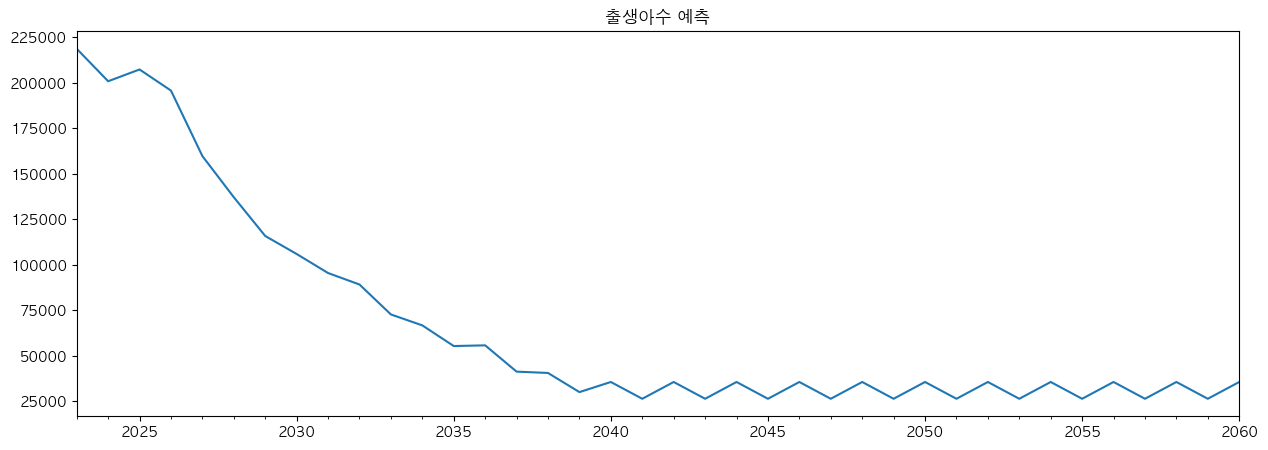

In [20]:
df_forecast['출생아수'].plot(figsize = (15, 5), title = '출생아수 예측')

In [21]:
df_forecast.to_csv("../result/VAR_출생아수예측.csv")